<h1>Import Required Libraries</h1>

In [36]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

<h1>Data Preprocessing</h1>

In [37]:
my_data_dir = 'D:\\Pycharm\\Anomalous_detection_CNN\\data_four_poses'

In [38]:
os.listdir(my_data_dir) 

['test', 'train']

In [39]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [40]:
os.listdir(test_path)

['climb', 'crawl', 'normal', 'squat']

In [41]:
os.listdir(train_path)

['climb', 'crawl', 'normal', 'squat']

In [42]:
os.listdir(train_path+'\\normal')[0]

'Image0.png'

In [43]:
stick_figure = train_path+'\\normal'+'\\Image0.png'

In [44]:
stick_fig_img = imread(stick_figure)

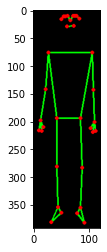

In [45]:
plt.imshow(stick_fig_img)

In [46]:
stick_fig_img.shape

(392, 121, 3)

In [47]:
len(os.listdir(train_path+'\\normal'))

1300

In [48]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\normal'):
    
    img = imread(test_path+'\\normal'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

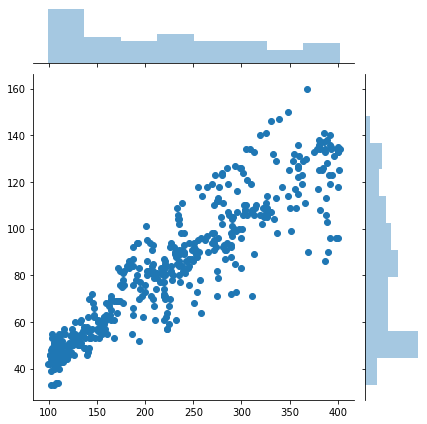

In [49]:
sns.jointplot(dim1,dim2)

In [50]:
np.mean(dim1)

220.694

In [51]:
np.mean(dim2)

81.036

In [52]:
image_shape = (225,85,3)

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [54]:
image_gen = ImageDataGenerator(rotation_range=0, # rotate the image 20 degrees
                               width_shift_range=0.0, # Shift the pic width by a max of 5%
                               height_shift_range=0.0, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.0, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.0, # Zoom in by 10% max
                               horizontal_flip=False, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

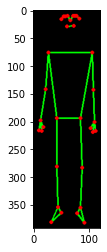

In [55]:
plt.imshow(stick_fig_img)

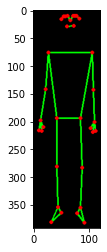

In [56]:
plt.imshow(image_gen.random_transform(stick_fig_img))

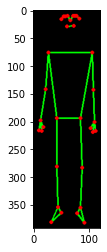

In [57]:
plt.imshow(image_gen.random_transform(stick_fig_img))

In [58]:
image_gen.flow_from_directory(train_path)

Found 5200 images belonging to 4 classes.


In [59]:
image_gen.flow_from_directory(test_path)

Found 2000 images belonging to 4 classes.


In [60]:
batch_size = 16

In [61]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 5200 images belonging to 4 classes.


In [62]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False)

Found 2000 images belonging to 4 classes.


In [63]:
train_image_gen.class_indices

{'climb': 0, 'crawl': 1, 'normal': 2, 'squat': 3}

<h1>Define LeNet architecture</h1>

In [122]:
def lenet(input_shape, n_classes):
    input = Input(input_shape)

    x = Conv2D(96, 5, strides=4, padding='same', activation='relu')(input)
    x = AvgPool2D(2, strides=2)(x)

    x = Conv2D(256, 5, padding='same', activation='relu')(x)
    x = AvgPool2D(2, strides=2)(x)

    x = Flatten()(x)
    x = Dense(120, activation='relu')(x)

    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    return model

In [123]:
input_shape = 225, 85, 3
n_classes = 4

K.clear_session()
model = lenet(input_shape, n_classes)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 225, 85, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 22, 96)        7296      
_________________________________________________________________
average_pooling2d_1 (Average (None, 28, 11, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 11, 256)       614656    
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 5, 256)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 17920)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               2150

In [124]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [125]:
from tensorflow.keras.callbacks import EarlyStopping

In [126]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [127]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
325/325 [==============================] - 105s 322ms/step - loss: 0.1385 - accuracy: 0.9546 - val_loss: 0.0280 - val_accuracy: 0.9820
Epoch 2/20
325/325 [==============================] - 105s 322ms/step - loss: 0.0445 - accuracy: 0.9860 - val_loss: 0.0079 - val_accuracy: 0.9735
Epoch 3/20
325/325 [==============================] - 105s 323ms/step - loss: 0.0208 - accuracy: 0.9933 - val_loss: 9.5771e-04 - val_accuracy: 0.9805
Epoch 4/20
325/325 [==============================] - 104s 321ms/step - loss: 0.0128 - accuracy: 0.9962 - val_loss: 0.0013 - val_accuracy: 0.9815
Epoch 5/20
325/325 [==============================] - 105s 324ms/step - loss: 0.0084 - accuracy: 0.9973 - val_loss: 3.9132e-04 - val_accuracy: 0.9845
Epoch 6/20
325/325 [==============================] - 105s 322ms/step - loss: 7.0101e-04 - accuracy: 1.0000 - val_loss: 2.0936e-04 - val_accuracy: 0.9875
Epoch 7/20
325/325 [==============================] - 105s 323ms/step - loss: 6.4721e-05 - accuracy: 1.0000 

<h1>Visualize and Evaluate metrics</h1>

In [128]:
from tensorflow.keras.models import load_model
model.save('LeNET_four_poses_2.h5')

In [129]:
losses = pd.DataFrame(model.history.history)

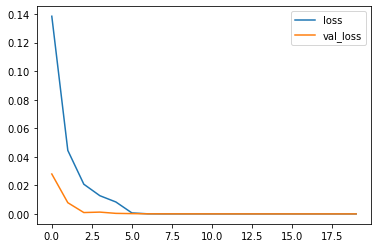

In [130]:
losses[['loss','val_loss']].plot()

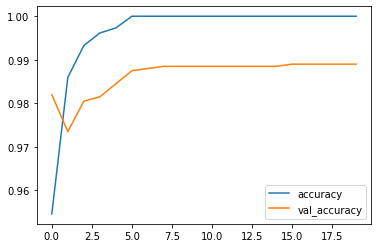

In [131]:
losses[['accuracy','val_accuracy']].plot()

<h1>Test the model</h1>

In [132]:
model.evaluate_generator(test_image_gen)

[9.305090316047426e-06, 0.9890000224113464]

In [133]:
predictions = model.predict(test_image_gen)

In [134]:
predictions

array([[1.0000000e+00, 2.5989794e-10, 1.1779577e-11, 1.4052086e-10],
       [1.0000000e+00, 3.0132230e-11, 2.9416357e-12, 5.2974543e-12],
       [1.0000000e+00, 2.1664410e-09, 9.7785387e-14, 4.5113405e-10],
       ...,
       [2.0109191e-10, 1.0653375e-11, 1.1442377e-08, 1.0000000e+00],
       [1.2579463e-08, 4.4943500e-11, 1.9335447e-08, 1.0000000e+00],
       [2.2384026e-09, 1.2007092e-12, 2.0866624e-10, 1.0000000e+00]],
      dtype=float32)

In [135]:
def prediction_classes(p):
    max_value  = 0
    maxi = 0
    for i in range(4):
        temp = p[i]
        if temp>max_value:
            max_value = temp
            maxi = i
    return maxi

In [136]:
predictions = map(prediction_classes, predictions)

pred = list(predictions)

In [137]:
pred = np.array(pred)

In [138]:
pred

array([0, 0, 0, ..., 3, 3, 3])

In [139]:
test_image_gen.classes

array([0, 0, 0, ..., 3, 3, 3])

In [140]:
from sklearn.metrics import classification_report,confusion_matrix

In [141]:
print(classification_report(test_image_gen.classes,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       500
           1       1.00      0.99      0.99       500
           2       0.98      0.98      0.98       500
           3       0.98      0.99      0.99       500

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [142]:
confusion_matrix(test_image_gen.classes,pred)

array([[498,   1,   1,   0],
       [  2, 494,   2,   2],
       [  1,   0, 492,   7],
       [  0,   1,   5, 494]], dtype=int64)

In [143]:
test_image_gen.class_indices

{'climb': 0, 'crawl': 1, 'normal': 2, 'squat': 3}